<span style="color:#b01604;font-weight:700;font-size:30px"> 
Phase I - Baseline CNN Model and Transfer Learning Review
</span> <br>
Harold Haugen <br>

Initial CNN Build to assess performance with the landslide image population attained. 


#### **Overview:** 
This notebook establishes our foundational approach to landslide detection from satellite imagery using two models:

1. **Baseline CNN**: Simple 5-layer architecture (~2.8M parameters) built from scratch
2. **EfficientNetB3 Transfer Learning**: Pre-trained ImageNet model with frozen base layers and custom classification head

#### **Objectives:** 
- Validate Dropbox data pipeline for large image datasets (~3GB). Data compiled with various sources. 
- Establish baseline performance metrics
- Demonstrate transfer learning effectiveness on satellite imagery
- Compare performance across datasets of varying size and diversity

#### **Dataset Configurations:** 
- **Set 1** (2,000 images): Homogeneous Longxi River UAV imagery
- **Set 2** (3,200 images): Multi-source (Longxihe, Lombok, Moxitown, Hokkaido)
- **Set 3** (6,974 images): Expanded with high-resolution aerial views
- **Set 4** (7,132 images): Combined with 168 manually sourced NASA events

Binary classification: **Class 0** (Landslide) vs **Class 1** (Non-Landslide)

#### **Model Architecture Overview** 
#### *Baseline CNN*

Simple convolutional architecture with progressive feature extraction:
**Architecture:** 3 Conv2D blocks (16→32→64 filters, 2×2 kernels) → Flatten → Dense(32) → Output(2)  
**Parameters:** ~2.8M | **Depth:** 5 layers | **Size:** 10.47 MB

#### *EfficientNetB3 Transfer Learning*

Pre-trained model with frozen ImageNet weights and custom classification head:
**Architecture:** EfficientNetB3 (frozen) → GlobalAvgPool → BatchNorm → Dropout(0.2) → Output(2)  
**Parameters:** 12.3M (12.0M frozen, 0.3M trainable) | **Depth:** 210 layers | **Size:** 48 MB

#### **Training Configurations:** 
- **Epochs**: 10-15
- **Batch size**: 32
- **Input size**: 300×300 pixels
- **Train/Val split**: 80/20 (stratified)
- **Optimizer**: Adam (lr=1e-3)
- **Loss**: Sparse categorical crossentropy
- **Metrics**: Accuracy, Precision, Recall, F1-Score

#### **Expected Results** 

| Model | Train Acc | Val Acc | Test Acc | Notes |
|-------|-----------|---------|----------|-------|
| Baseline CNN | ~85-90% | ~85-90% | ~50-60% | May overfit on homogeneous data |
| EfficientNetB3 | >95% | >95% | ~60-70% | Better generalization via ImageNet features |

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib

2024-12-09 23:16:23.806727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 23:16:23.831017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 23:16:23.843662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 23:16:23.847440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 23:16:23.859496: I tensorflow/core/platform/cpu_feature_guar

### **Helper functions**
- Method to resize images to a standardized size to align with the CNN model expectations (e.g., 300x300).

In [6]:
## Resize Image Size and Printer Helper
def resize_show(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(300,300)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    plt.imshow(img)
    plt.axis('off')  # Optional: turn off the axis
    plt.show()

### **Data Pull**
- Data stored in DropBox for groupwide access.
- Various image files constructed and communicated to team as versions improved. 

In [7]:
# Specify the path to the zip file:
# dataset_url = "https://dl.dropboxusercontent.com/scl/fi/hgz1prxm1kx14w5riy9du/ls_model_data_three.zip?rlkey=7cv22qxmmaeofr7jn6z7iayjy&dl=0?raw=1"
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/vmox93cwsx2vzrish3l63/land_ls_model_data_four.zip?rlkey=6uykz7bb0aoqbl8hgfkpt1t4f&dl=0?raw=1"
# dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1"

In [8]:
data_dir = tf.keras.utils.get_file('land_ls_model_data_four.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3200


In [10]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
print("Folders in the dataset directory:")
for folder in folders:
    print(folder.name)

Folders in the dataset directory:
landslide
non_landslide


In [11]:
land_class_num = len(folders)
land_class_num

2

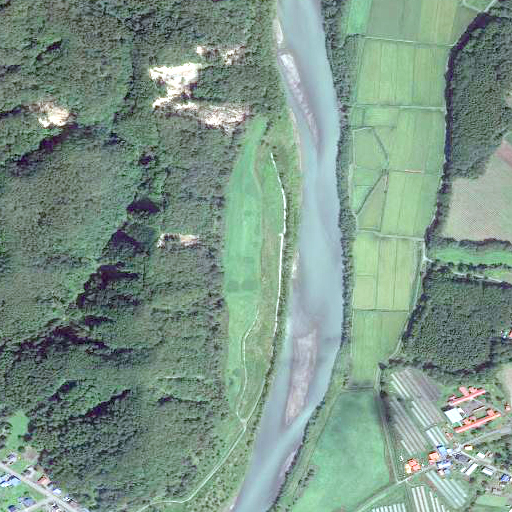

In [12]:
## Review an image
landslide_one = list(data_dir.glob('landslide/*'))
PIL.Image.open(str(landslide_one[2]))

### **Pull in Separate Test Dataset**

In [13]:
### Specify the path to the zip file
# https://www.dropbox.com/scl/fi/wbi8iuftwvwnflvjr15pv/test_googleimages_land.zip?rlkey=h2stfvt9ocltsog29l26wo1ls&dl=0
# https://www.dropbox.com/scl/fi/w6fa6pd6hq7815p0jgkm2/test_google_images_landslides_two.zip?rlkey=zxiexqgti6b2nyemywc3itmhm&dl=0
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/w6fa6pd6hq7815p0jgkm2/test_google_images_landslides_two.zip?rlkey=zxiexqgti6b2nyemywc3itmhm&dl=0?raw=1"
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/kl3e9wxoibqu0ldogwxg0/test_google_images_landslides_five.zip?rlkey=zuhh6xvjy3oi9wuroy4ogtdi3&dl=0?raw=1"

In [14]:
### Pulling in the data set. 
data_dir_test = tf.keras.utils.get_file('test_google_images_landslides_five.zip', origin=test_dataset_url, extract=True)
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

In [15]:
## Review folders within the zip / incoming data / classes.
folders = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images
Test_Images_Duplicates


In [16]:
## Drill into each subdirectory and list files for review. 
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 65 .jpg images
  Subfolder: non-landslides
non-landslides: 77 .jpg images
  File: .DS_Store

Contents of folder 'Test_Images_Duplicates':
  File: nasa_g_4263m_12654_2023_cat.jpg
  File: nasa_g_3015m_12654_2023_cat.jpg
  File: nasa_g_4161m_11542_2021_cat.jpg
  File: nasa_g_2785m_11542_2021_cat_town.jpg
  File: nasa_g_4800m_10029_2019_vylg.jpg
  File: nasa_g_4800m_9304_2017_vylg.jpg
  File: nasa_g_4250m_12699_2019_large_v2.jpg


In [17]:
## Review an image
test_one = list(data_dir_test.glob('Google_Earth_Images/landslides/*'))
# PIL.Image.open(str(test_one[2]))

2024-12-09 23:16:58.978347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1002 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:04:00.0, compute capability: 8.6


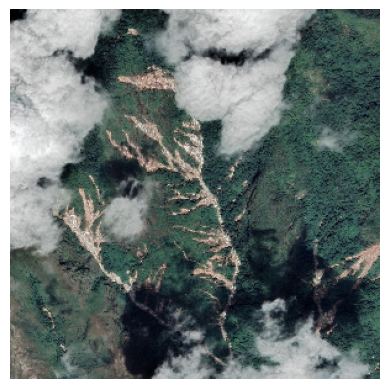

In [18]:
resize_show(test_one[2])

### **Training: Setting up Data**

In [19]:
## Set Batch, Image size and number of Classes. 
batch_size = 32
img_height = 300
img_width = 300

In [20]:
land_class_num

2

In [21]:
## Set Training Set image set. 
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="training",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.


In [22]:
## Setup Valiation set.
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="validation",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3200 files belonging to 2 classes.
Using 640 files for validation.


In [23]:
## Review class names based on dataset. 
class_names = train_dataset.class_names
print(class_names)

['landslide', 'non_landslide']


In [24]:
## Review sizes of images. 
counter_d = 0
for images, labels in train_dataset:
    if counter_d < 3:
        print(images.shape, labels.shape)
    counter_d += 1

(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)
(32, 300, 300, 3) (32,)


2024-12-09 23:17:02.006160: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Buffering/Shuffle

In [25]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

2024-12-09 23:17:04.691892: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


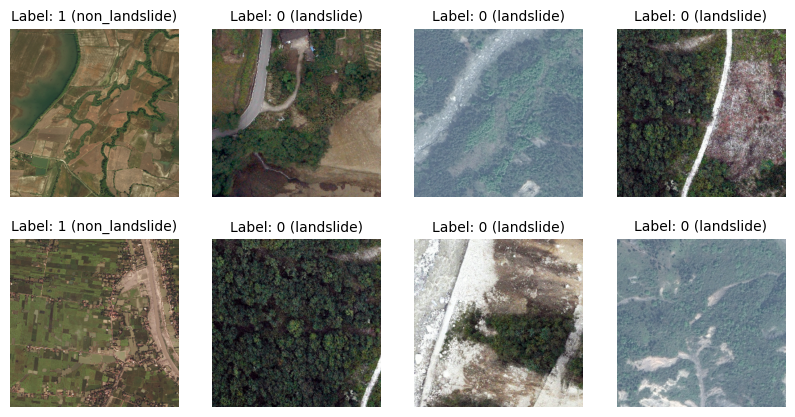

In [26]:
## Checking the Labels. 
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()


### **Test Set**

In [27]:
## Update path given the Google_Earth_Images/landslide vs. non-landslide directory structure. 
data_dir_test_lvltwo=pathlib.Path(data_dir_test) / 'Google_Earth_Images'
data_dir_test_lvltwo

PosixPath('/home/waa4bq/.keras/datasets/test_google_images_landslides_five_extracted/Google_Earth_Images')

In [28]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test_lvltwo,   # Base directory
    labels='inferred',           # Automatically assign labels based on folder names
    subset=None,                 # No split; we are directly specifying test data
    seed=512,                    # Random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  ### Add because the labels and images were getting mixed up in processing. 
    validation_split=None,       # No validation split; test data only
)

Found 142 files belonging to 2 classes.


In [29]:
## Review class names based on dataset. 
class_names = test_dataset.class_names
print(class_names)

['landslides', 'non-landslides']


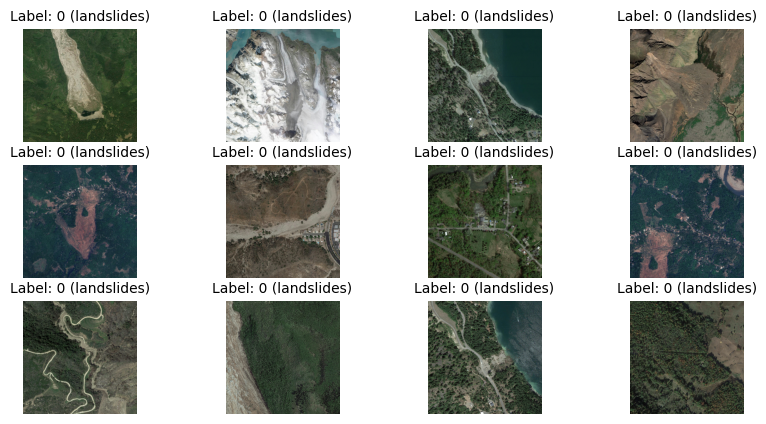

In [30]:
## Checking the Labels. 
plt.figure(figsize=(10, 5))
for images, labels in test_dataset.take(1):  # Take one batch
    for i in range(12):  # Display first 6 samples
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:10px solid gray">

**<span style="color:#0638b2; font-size:30px">
Model Design - Baseline CNN
</span>** <br>
- This section holds our initial baseline CNN design for review.
- Details below. 

#### **Visualization / Plot Helper**

In [31]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

<hr style="border:4px solid gray">

#### **Design CNN Model Baseline**
- The baseline CNN serves as a performance benchmark built from scratch without pre-trained weights. The architecture consists of three convolutional blocks (16, 32, 64 filters with 2×2 kernels), max pooling for spatial reduction, and a simple dense layer for binary classification. This lightweight model (~2.8M parameters) helps validate that the landslide detection task is learnable and provides a reference point for measuring transfer learning improvements.

In [32]:
ls_model_ph_one = Sequential([
  # data_augmentation,  ## Data Augmentation
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Dropout(0.2),  ## Dropout
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),  ## Dropout
    layers.Dense(2, activation='softmax')   ### Use with SparseCategoricalCrossentropy
    # layers.Dense(1, activation='sigmoid')   ### Use with BinaryCrossentropy
])

/home/waa4bq/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compile**

In [33]:
## Setup model: Optmizer, Loss, Metrics
ls_model_ph_one.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.001),
            loss='sparse_categorical_crossentropy',
              # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                         # loss='binary_crossentropy',
              metrics=['accuracy'])

In [34]:
ls_model_ph_one.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 300, 300, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     2,803,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,814,354 (10.74 MB)

 Trainable params: 2,814,354 (10.74 MB)

 Non-trainable params: 0 (0.00 B)

#### **Fit**
ls_model_ph_one

In [ ]:
## Fit Model
epochs = 10
landslide_history_one = ls_model_ph_one.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs
)

In [ ]:
## Plot results
visualize_model_results(landslide_history_one)

#### **Testing**

In [ ]:
print("Evaluate on test landslide images")
results = ls_model_ph_one.evaluate(test_dataset)
print("test loss, test acc:", results)

In [ ]:
# Get predictions and true labels
y_pred_probs = ls_model_ph_one.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

In [ ]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()

print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases that are identified. {recall_val}')
specificity_val = round(TN/(TN+FP),3);
print(f'Specificity: TN / (TN + FP) | Actual negative cases that are identified. {specificity_val}')

F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

### Identify Image File to Prediction|True Labels

In [ ]:
# Assuming you already have your test_dataset loaded
file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample

# Print a few file paths to confirm
print("Sample file paths:")
for file in file_paths[:10]:  # Preview first 5 paths
    print(file)

In [ ]:
# Get predictions
y_pred_probs = ls_model_ph_one.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels

print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")


<hr style="border:7px solid darkred">

**<span style="color:#0638b2; font-size:30px">
Model Design w/ Transfer Learning
</span>** <br>
- In this section, we pull in the EfficientNet model and fit a baseline model where we only re-train the top layer.
- See Details below.
  
#### Pre-Training with EfficientNet
- Strengths: EfficientNet models scale well in terms of parameters and efficiency, balancing accuracy with computational cost, which is especially useful for large datasets.
- Suitability: EfficientNet performs exceptionally well on high-resolution images, which is ideal for detecting fine details in satellite images.
- https://viso.ai/deep-learning/efficientnet/
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

#### Setting up EfficientNet
- Note - using B3 as this is set up for 300x300 images. 

In [ ]:
## Import the EfficientNetB3 model specifically
from tensorflow.keras.applications import EfficientNetB3

In [ ]:
# Setting up parameters for model. 
IMG_SIZE=300
learn_rate_land = .001  ## For optimizer.
print(land_class_num) ## Check class number AND use as argument below.

#### **Helper Functions**

Saturation
- The saturation factor is sampled randomly from a uniform distribution in the range [lower, upper].
- A saturation factor of 1.0 means no change in saturation.
- A saturation factor below 1.0 decreases the saturation (the image will appear less vibrant or more grayscale).
- A saturation factor above 1.0 increases the saturation (the image will appear more vibrant).

In [ ]:
## Helper Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(factor=0.10),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(factor=0.3),
    # layers.RandomSaturation(.7, seed=516) ## Error
    layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.1, upper=1.1))
  ]
)

### **Design CNN Model Baseline**
- We now leverage transfer learning with EfficientNetB3, a state-of-the-art architecture pre-trained on ImageNet. By freezing all 210 base layers, we preserve learned low-level features (edges, textures, patterns) while training only a custom classification head for landslide detection. This approach dramatically reduces training time and parameters while improving generalization.

#### *Key Design Choices*

**Data Augmentation at Input**  
Applied directly to the model input for GPU acceleration during training. Includes random cropping, saturation, brightness, and contrast adjustments to improve generalization.

**Frozen Base Layers**  
All 210 EfficientNetB3 layers remain frozen (`model.trainable = False`), preserving ImageNet-learned features. This reduces trainable parameters from 12.3M to ~0.3M.

**Global Average Pooling**  
Replaces `Flatten()` to reduce parameters. Converts (10×10×1280) → (1280,) by averaging each channel spatially. This prevents the parameter explosion seen in the baseline CNN's dense layer.

**Batch Normalization**  
Normalizes activations between pooling and dropout layers, stabilizing training and accelerating convergence.

**Conservative Learning Rate**  
Adam optimizer with `lr=1e-3` (0.001) prevents destabilizing the pre-trained representations during classification head training.

### Expected Improvements Over Baseline

- **Higher accuracy**: Pre-trained features generalize better than scratch-learned features
- **Faster training**: Only ~0.3M parameters to train vs 2.8M in baseline
- **Better test performance**: ImageNet features transfer well to satellite imagery
- **Reduced overfitting**: Frozen base acts as strong regularization

**Parameters:** 12.3M total (12.0M frozen, 0.3M trainable) | **Size:** 48 MB | **Input:** 300×300×3

---

In [ ]:
# Create the base Transfer Learning model from the pre-trained model EfficientNetB3.
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


#### **Fit**

In [ ]:
landslide_model_ENB3 = build_model(num_classes=land_class_num)

epochs = 10  # @param {type: "slider", min:8, max:80}
landslide_ENB3_hist = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset)


In [ ]:
## Plot results
visualize_model_results(landslide_ENB3_hist)

### **Testing**

In [ ]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

In [ ]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

In [ ]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Extract Confusion Matrix Components and Compute Metrics

In [ ]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()

print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases that are identified. {recall_val}')
specificity_val = round(TN/(TN+FP),3);
print(f'Specificity: TN / (TN + FP) | Actual negative cases that are identified. {specificity_val}')

F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

In [ ]:
# file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample
# # Get predictions
# y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
# y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels

print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true & true == 0:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")


<hr style="border:2px solid gray">

## Testing a single image.

#### Helper Functions

In [ ]:
## Prediction Helper
def predict_landslide_image(image_path, model):
    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width) )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    # score = tf.nn.softmax(predictions[0])
    score = predictions[0]

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

---

### Image One

In [ ]:
## Load Image
landslide_img_one_url = "https://dl.dropboxusercontent.com/scl/fi/viovy9pcma2y6hq58ntns/NASA_GoogE_14445.jpg?rlkey=ltitymrzuarrxxogge32c1kbi&dl=0?raw=1"
landslide_img_one_path = tf.keras.utils.get_file('NASA_GoogE_14445', origin=landslide_img_one_url)

In [ ]:
resize_show(landslide_img_one_path)

#### **Prediction**

In [ ]:
predict_landslide_image(landslide_img_one_path, landslide_model_ENB3)

### Image Two

In [ ]:
landslide_img_two_url = "https://dl.dropboxusercontent.com/scl/fi/7x41si7aih0bjh1py2phy/NASA_GoogE_14445_NonSlide.jpg?rlkey=3ll97pdrjwr9b10rcvineeynm&dl=0?raw=1"
landslide_img_two_path = tf.keras.utils.get_file('NASA_GoogE_14445_NonSlide', origin=landslide_img_two_url)

In [ ]:
resize_show(landslide_img_two_path)

#### **Prediction**

In [ ]:
predict_landslide_image(landslide_img_two_path, landslide_model_ENB3)

### **End**